In [1]:
import numpy as np
from numpy.lib.stride_tricks import as_strided
from keras.models import Sequential
from keras.layers import GRU, Dense, Reshape
from keras.optimizers import Adam
import tqdm
import warnings
warnings.filterwarnings('ignore')
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


# AWS CPU Utilization Dataset

In [2]:
data=pd.read_csv("data/rds_cpu_utilization_e47b3b.csv", header=0)
data.head()

,timestamp,value
0,2014-04-10 00:02:00,14.012
1,2014-04-10 00:07:00,13.334
2,2014-04-10 00:12:00,15.000
3,2014-04-10 00:17:00,13.998
4,2014-04-10 00:22:00,14.332


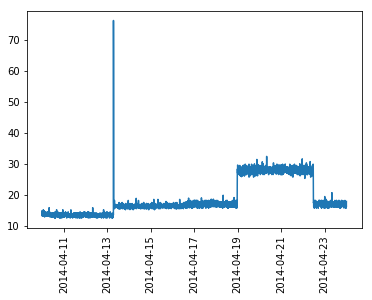

In [3]:
data["timestamp"] = pd.to_datetime(data["timestamp"], 
                                   format="%Y-%m-%d %H:%M:%S")

plt.plot(data["timestamp"],data["value"])
plt.xticks(rotation=90)
plt.show()

## We use the past n_lag time steps to predict n_seq time steps in the future

In [4]:
def as_sliding_window(ts, wl):
    assert len(ts.shape) == 1
    ss = ts.strides[0]
    n = ts.shape[0]
    return as_strided(ts, shape=[n-wl+1, wl], strides=[ss, ss])


def prepare_scalar_timeseries(ts, n_lag, n_seq, split_index, normalize=True):
    n_samples = ts.shape[0]
    ts_strided = as_sliding_window(ts, n_lag+n_seq)
    ts_strided = ts_strided[..., np.newaxis]
    X, Y = np.split(ts_strided, [n_lag], axis=1)
    if normalize:
        X_mean = X.mean(axis=1, keepdims=True)
        X_std = X.std(axis=1, keepdims=True)
        X = (X - X_mean) / X_std
        Y = (Y - X_mean) / X_std
    X_train, X_test = np.split(X, [split_index])
    Y_train, Y_test = np.split(Y, [split_index])
    return (X_train, Y_train), (X_test, Y_test)

In [5]:
(X_train, Y_train), (X_test, Y_test) = \
    prepare_scalar_timeseries(ts=data["value"].values, n_lag=3, n_seq=2, split_index=10, normalize=False)

In [6]:
data.head()

,timestamp,value
0,2014-04-10 00:02:00,14.012
1,2014-04-10 00:07:00,13.334
2,2014-04-10 00:12:00,15.000
3,2014-04-10 00:17:00,13.998
4,2014-04-10 00:22:00,14.332


In [7]:
X_train[0]

array([[14.012],
       [13.334],
       [15.   ]])

In [8]:
Y_train[0]

array([[13.998],
       [14.332]])

In [9]:
data[10:].head()

,timestamp,value
10,2014-04-10 00:52:00,13.334
11,2014-04-10 00:57:00,15.046
12,2014-04-10 01:02:00,13.332
13,2014-04-10 01:07:00,15.000
14,2014-04-10 01:12:00,15.000


In [10]:
X_test[0]

array([[13.334],
       [15.046],
       [13.332]])

In [11]:
Y_test[0]

array([[15.],
       [15.]])

## Getting the unnormalized anomaly scores

In [12]:
def saurav_anomaly_score(y_true, y_predicted):
    l = y_true.shape[1]  # l-step prediction
    d = len(y_true.shape)
    a = np.square(y_true - y_predicted).sum(axis=tuple(range(1,d))) / l
    return a

# Define the RNN

In [13]:
def fit_rnn(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    """Train a multi-step RNN"""
    # design network
    x, y = train
    model = Sequential()
    # L = 1,2,3 dropout is .2 and learning rate is .0005 and number of cells in each layer is n_neurons
    model.add(GRU(n_neurons, input_shape=(x.shape[1], x.shape[2]), dropout=0.2, stateful=False, return_sequences=True))
    model.add(GRU(n_neurons, dropout=0.2, stateful=False, return_sequences=True))
    model.add(GRU(n_neurons, dropout=0.2, stateful=False))
    model.add(Dense(y.shape[1]*y.shape[2]))
    model.add(Reshape([y.shape[1], y.shape[2]]))
    # sgd = optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True)
    adam = Adam(lr=0.0005, beta_1=.5)
    model.compile(loss='mean_squared_error', optimizer=adam)
    model.summary()
    # fit network
    model.fit(x, y, epochs=nb_epoch, batch_size=n_batch, verbose=1, shuffle=False)
    return model

In [14]:
def rnn(ts, n_lag, n_seq, n_test, n_epochs, n_batch, n_neurons, training_index, local_normalization=True):
        """
        Input:

        n_lag = number of observations as input

        n_seq = number of observations as output

        n_test = the last n_test time steps form the test set

        n_epochs = number of epochs

        n_batch = batch size

        n_neurons = number of cells in each layer

        training_index = to separate training set from rest of set for determining anomaly scores

        local_normalization = Standardize x(t) and y(t) using mean and std of x(t)
        """
        
        start = time.time()

        (X_train, Y_train), (X_test, Y_test) = \
            prepare_scalar_timeseries(ts, n_lag, n_seq, training_index, normalize=local_normalization)

        model = fit_rnn((X_train, Y_train), n_lag, n_seq, n_batch, n_epochs, n_neurons)
       
        predictions = np.zeros((len(X_train)+len(X_test), n_seq, 1))
        predictions[:training_index] = model.predict(X_train)

        with tqdm.tqdm(total=len(X_test)) as t:
            for i, (x, y) in enumerate(zip(X_test, Y_test)):
                predictions[training_index+i] = model.predict_on_batch(x[np.newaxis])
                model.train_on_batch(x[np.newaxis], y[np.newaxis])
                t.update()

        raw_anomaly_scores = np.zeros(len(predictions))
        raw_anomaly_scores[:training_index] = saurav_anomaly_score(Y_train, predictions[:training_index])
        raw_anomaly_scores[training_index:] = saurav_anomaly_score(Y_test, predictions[training_index:])

        predictions_index = np.arange(len(predictions))+n_lag+n_seq-1
        predictions = pd.DataFrame(predictions.squeeze(2), index=predictions_index)

        error_anomaly_scores_series = pd.Series(raw_anomaly_scores, index=predictions_index, name='Raw Anomaly Score')

        padded_error_anomaly_scores_y_values = np.append(np.zeros(n_lag+n_seq-1), raw_anomaly_scores).tolist()

        end = time.time()
        
        print("Time:", end - start)
        
        plt.scatter(error_anomaly_scores_series.index, error_anomaly_scores_series.values)
        plt.show()
        
        return error_anomaly_scores_series

## Fit the RNN and get unnormalized anomaly scores

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 100, 40)           5040      
_________________________________________________________________
gru_2 (GRU)                  (None, 100, 40)           9720      
_________________________________________________________________
gru_3 (GRU)                  (None, 40)                9720      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 205       
_________________________________________________________________
reshape_1 (Reshape)          (None, 5, 1)              0         
Total params: 24,685
Trainable params: 24,685
Non-trainable params: 0
_________________

100%|██████████| 3324/3324 [04:45<00:00, 11.62it/s]


Time: 744.4521250724792


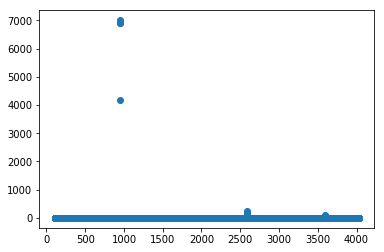

In [15]:
error_anomaly_scores_series_1 = rnn(ts=data["value"].values, training_index=int(.15*len(data)),n_lag=100, n_seq=5, n_test=20, n_epochs=10, n_batch=1,n_neurons=40)

## Try increasing n_seq

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 100, 40)           5040      
_________________________________________________________________
gru_5 (GRU)                  (None, 100, 40)           9720      
_________________________________________________________________
gru_6 (GRU)                  (None, 40)                9720      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2050      
_________________________________________________________________
reshape_2 (Reshape)          (None, 50, 1)             0         
Total params: 26,530
Trainable params: 26,530
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
604/604 [==============================] - 47s 78ms/step - loss: 1.0339
Epoch 2/10
604/604 [==============================] - 4

100%|██████████| 3279/3279 [04:43<00:00, 11.56it/s]


Time: 744.718282699585


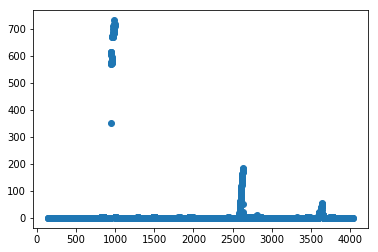

In [16]:
error_anomaly_scores_series_2 = rnn(ts=data["value"].values, training_index=int(.15*len(data)),n_lag=100, n_seq=50, n_test=20, n_epochs=10, n_batch=1,n_neurons=40)

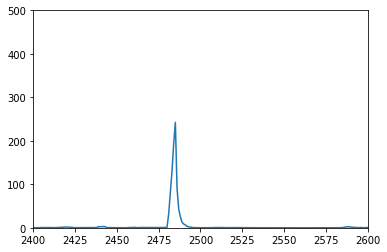

In [20]:
plt.plot([i for i in range(len(error_anomaly_scores_series_1))],error_anomaly_scores_series_1)
plt.xlim([2400,2600])
plt.ylim([0,500])
plt.show()

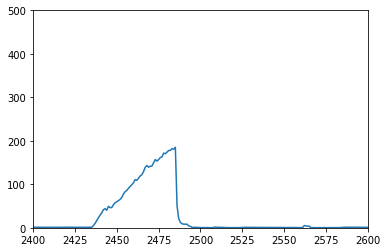

In [21]:
plt.plot([i for i in range(len(error_anomaly_scores_series_2))],error_anomaly_scores_series_2)
plt.xlim([2400,2600])
plt.ylim([0,500])
plt.show()

# Tidbits

1) Adams optimizer

https://arxiv.org/abs/1412.6980

2) Paper that this RNN was based off of

https://dl-acm-org.libproxy.unm.edu/citation.cfm?id=3152501

3) Optimizers to choose from

https://keras.io/optimizers/

4) GRUs vs LSTMs

https://datascience.stackexchange.com/questions/14581/when-to-use-gru-over-lstm